### Try other methods for interpreting MUSE output as a probability map

1. Just softmax the RSRP values and look at the calibration plot.
2. Try convolving a Gaussian kernel over the RSRP grid.

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats

def softmax(x: np.ndarray):
    return np.exp(x) / np.exp(x).sum()

In [2]:
import pickle

with open('dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [3]:
import muse

from config import (
    X_DIM, Y_DIM, RESOLUTION, F_HI, F_LO, TEMP, MIC_POS
    )


xgrid, ygrid = muse.make_xy_grid(X_DIM, Y_DIM, resolution=RESOLUTION)

r_ests = []
rsrp_grids = []

# for d in dataset:
#     _, ests, rsrp_grid = muse.r_est_jackknife(
#         d.signal,
#         d.sample_rate,
#         F_LO,
#         F_HI,
#         TEMP,
#         X_DIM,
#         Y_DIM,
#         RESOLUTION,
#         MIC_POS
#     )
#     r_ests.append(ests)
#     rsrp_grids.append(rsrp_grid)

In [4]:
# with open('rsrp_grids.pickle', 'wb') as f:
#     pickle.dump(rsrp_grids, f)

with open('rsrp_grids.pickle', 'rb') as f:
    rsrp_grids = pickle.load(f)

In [5]:
rsrp_grids[0][0].shape

(97, 73)

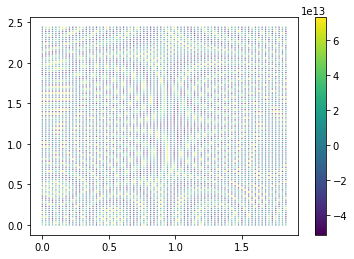

In [6]:
from matplotlib import pyplot as plt

plt.scatter(xgrid, ygrid, c=rsrp_grids[0][0], s=0.1)
plt.colorbar()
plt.show()

`r_est_jackknife` currently returns one RSRP grid for each point estimate it returns (one for each microphone). For now, let's just average those grids before passing them to softmax.

In [7]:
avgd_grids = [
    np.array(grids).mean(axis=0) for grids in rsrp_grids
    ]

Also notice that we have values up in the range `1e13`. Let's renormalize the data to a more normal range.

In [16]:
renormalized_grids = [
    g / g.max() for g in avgd_grids
]

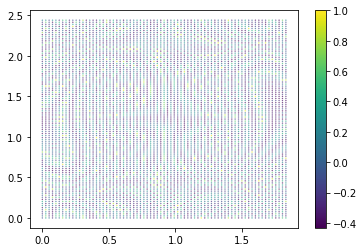

In [17]:
plt.scatter(xgrid, ygrid, c=renormalized_grids[0], s=0.1)
plt.colorbar()
plt.show()

Much better. Now apply softmax!

In [21]:
softmaxed_grids = [softmax(g) for g in renormalized_grids]

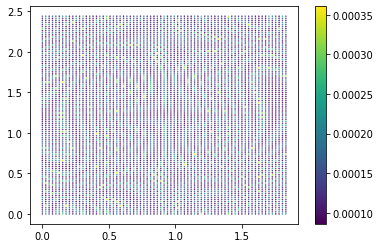

In [22]:
plt.scatter(xgrid, ygrid, c=softmaxed_grids[0], s=0.25)
plt.colorbar()
plt.show()

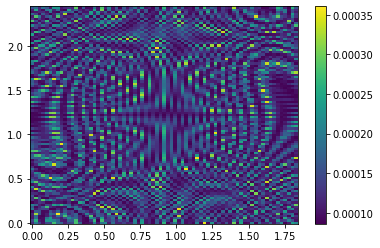

In [31]:
plt.pcolormesh(xgrid, ygrid, softmaxed_grids[0])
plt.colorbar()
plt.show()

now examime the calibration of these plots.

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.05   , 0.15   , 0.2    , 0.2875 , 0.35   , 0.40625, 0.50625,
        0.63125, 0.775  , 1.     ]))

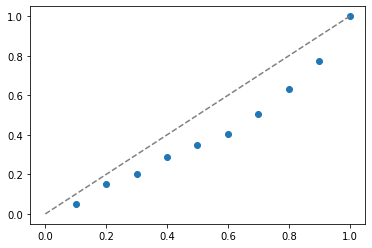

In [25]:
from calibration import calibration_curve

true_locations = [d.speaker_position[:2] for d in dataset]

calibration_curve(
    np.array(softmaxed_grids),
    np.array(true_locations),
    xgrid,
    ygrid,
)

That is surprisingly not awful.

#### 2. Try convolving the RSRP grids with a Gaussian kernel

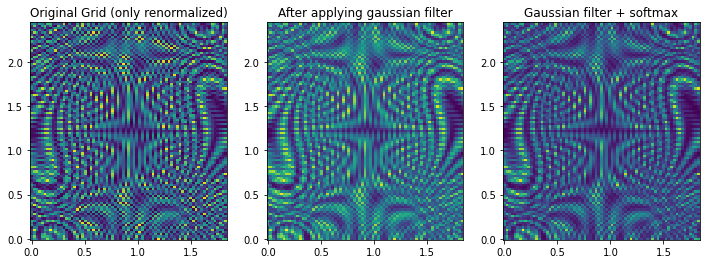

In [47]:
import scipy.ndimage

SIGMA = 0.5

out = scipy.ndimage.gaussian_filter(renormalized_grids[0], sigma=SIGMA)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))

ax0.pcolormesh(xgrid,ygrid, renormalized_grids[0])
ax0.set_title('Original Grid (only renormalized)')

ax1.pcolormesh(xgrid,ygrid, out)
ax1.set_title('After applying gaussian filter')

ax2.pcolormesh(xgrid, ygrid, softmax(out))
ax2.set_title('Gaussian filter + softmax')

plt.show()

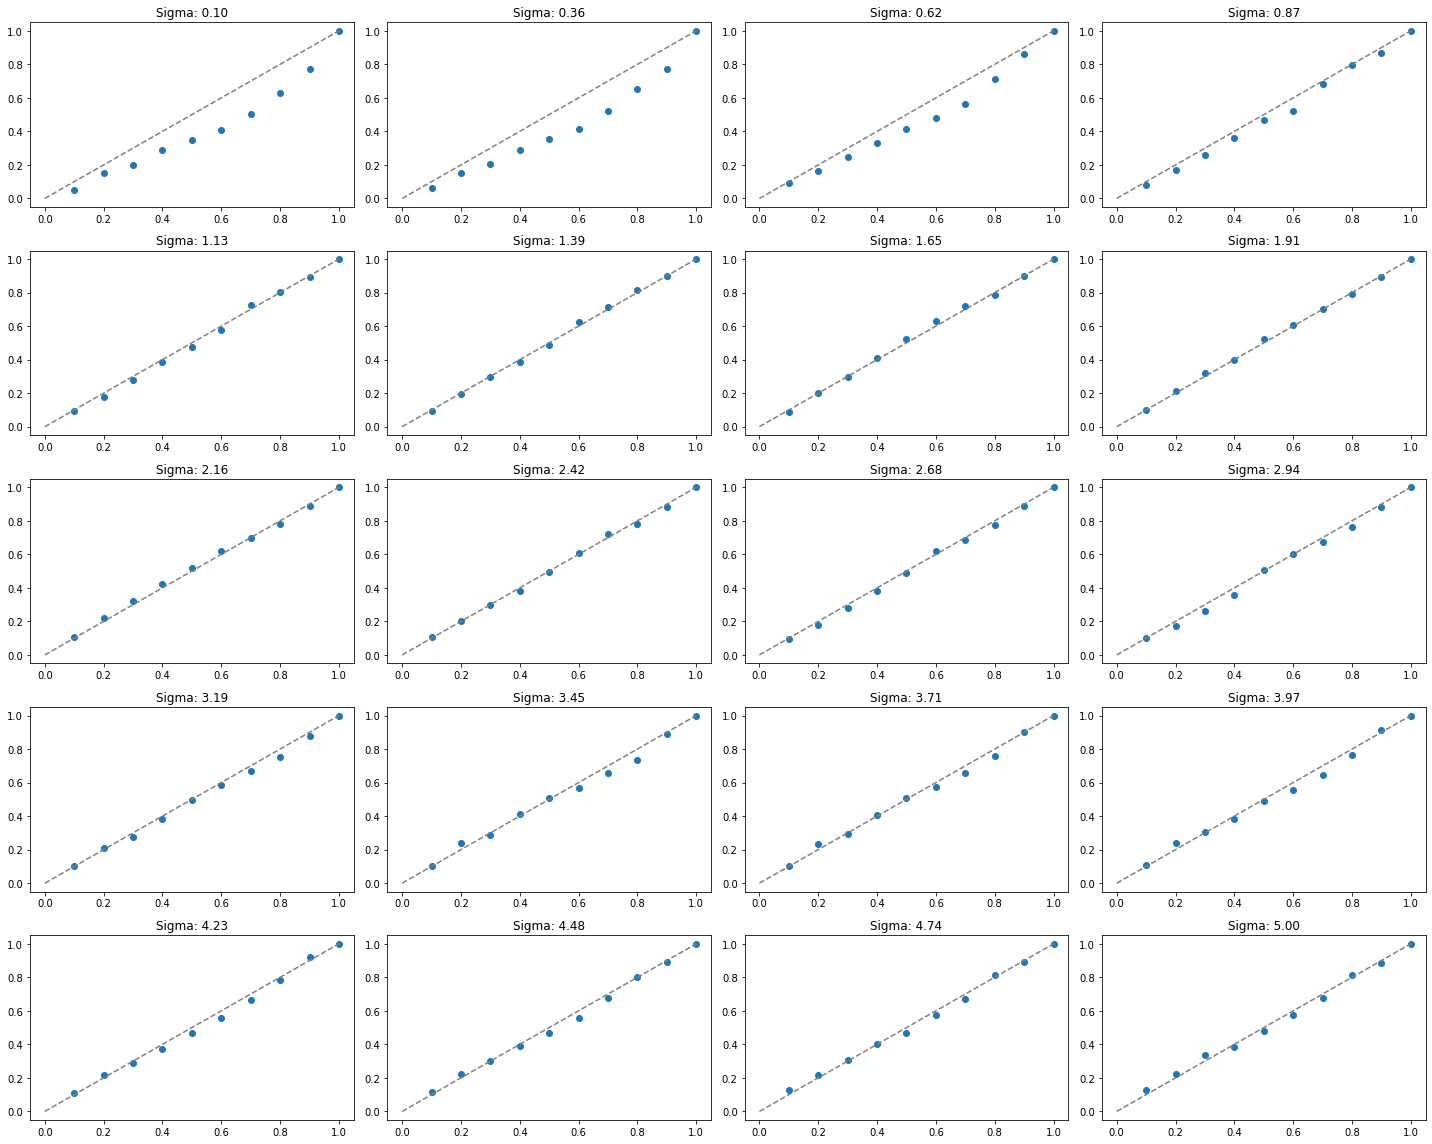

In [58]:
blurred_grids = lambda sigma: [
    softmax(scipy.ndimage.gaussian_filter(g, sigma=sigma))
    for g in renormalized_grids
]

fig, axs = plt.subplots(5, 4, figsize=(20, 16))

sigmas = np.linspace(0.1, 5, 20)
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        sigma = sigmas[i * len(row) + j]
        calibration_curve(
            np.array(blurred_grids(sigma)),
            np.array(true_locations),
            xgrid,
            ygrid,
            ax=ax
        )
        ax.set_title(f'Sigma: {sigma:0.2f}')

fig.tight_layout()
plt.show()

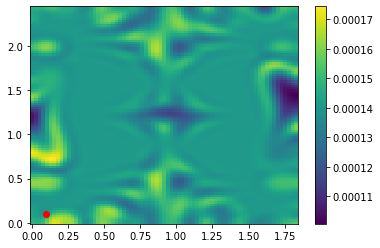

In [60]:
plt.pcolormesh(xgrid, ygrid, blurred_grids(2)[0])
plt.plot(true_locations[0][0], true_locations[0][1], 'ro')
plt.colorbar()
plt.show()